In [5]:
import numpy as np
from random import seed
from random import randrange
from csv import reader
import matplotlib.pyplot as plt

In [6]:
dataset=[]
file1 = open("./winequality-red.data", "r")
while True:
    one_data=[]
    line = file1.readline()
    if not line:
        break
    str_sep=line.split(";")
    for i in range(len(str_sep)-1):
      one_data.append(float(str_sep[i]))
    one_data.append(int(str_sep[-1]))
    
    dataset.append(one_data)
data_set=np.array(dataset)
# print(dataset)

In [7]:
from locale import nl_langinfo
def rand_data_set(dataset):
  dataset_copy = list(dataset)
  new_dataset=list()
  while len(dataset_copy):
    index = randrange(len(dataset_copy))
    new_dataset.append(dataset_copy.pop(index))
  return new_dataset

def cut_data_set(dataset,n_new_dataset):
  dataset_copy = list(dataset)
  new_dataset=list()
  for qq in range(n_new_dataset):
    index = randrange(len(dataset_copy))
    new_dataset.append(dataset_copy.pop(index))
  return new_dataset
  

In [8]:
dataset=rand_data_set(dataset)
# print(dataset)

In [21]:
def clusterization_draw(data,cluster_content,dim1,dim2):
  cluster_colors=['gainsboro', 'lightgrey', 'silver', 'darkgrey', 'gray', 'dimgray', 'black', 'darkred', 'purple']
  center_colors=['red','orangered','sienna', 'darkorange', 'tan', 'gold', 'lawngreen', 'darkseagreen', 'darkgreen']
  data_names=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
  leg=['cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7','cluster_8','cluster_9']
  n = len(data)
  k=len(cluster_content)
  plt.grid() 
  plt.xlabel(data_names[dim1])    
  plt.ylabel(data_names[dim2])
  for i in range(9): 
    x_coordinates = []
    y_coordinates = []
    for j in range(len(cluster_content)):
      if cluster_content[j]==i:
        x_coordinates.append(data[j][dim1])
        y_coordinates.append(data[j][dim2])
    plt.scatter(x_coordinates, y_coordinates,c=cluster_colors[i],label=leg[i])
  plt.legend()
  plt.show()  


In [10]:

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		# clusterization_draw(test_set,predicted,2,3)
		# clusterization_draw(test_set,actual,2,3)	
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups, 'b_score':b_score}

# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root

# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

# Print a decision tree
def print_tree(node, depth=0):
	data_names=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
	if isinstance(node, dict):
		#print('%s[X%d < %.3f]' % ((depth*'   ', (node['index']+1), node['value'])))
		print('%s[%s < %.3f], gini_value=%.3f' % ((depth*'   ', data_names[node['index']], node['value'],node['b_score'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[cluster_%s]' % ((depth*'   ', node)))
	
# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
	tree = build_tree(train, max_depth, min_size)
	predictions = list()
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
	#print_tree(tree)
	return(predictions)




In [11]:
# Test CART on Bank Note dataset
seed(1)
# load and prepare data

# convert string attributes to integers
#for i in range(len(dataset[0])):
	#str_column_to_float(dataset, i)
# evaluate algorithm
n_folds = 12
max_depth = 1
for i in range(7):
	min_size = 10
	for j in range(2):
		scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
		print('max_depth =',max_depth,' min_size =',min_size)
		print('Scores: %s' % scores)
		print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))
		print()
		min_size += 10
	max_depth +=1
	print('=========')
	

max_depth = 3  min_size = 5
Scores: [54.88721804511278, 50.37593984962406, 53.383458646616546, 52.63157894736842, 55.639097744360896, 53.383458646616546, 51.8796992481203, 59.3984962406015, 51.8796992481203, 59.3984962406015, 47.368421052631575, 48.87218045112782]
Mean Accuracy: 53.258%

max_depth = 3  min_size = 10
Scores: [49.62406015037594, 57.89473684210527, 58.64661654135338, 60.150375939849624, 49.62406015037594, 54.88721804511278, 46.616541353383454, 50.37593984962406, 50.37593984962406, 49.62406015037594, 54.88721804511278, 50.37593984962406]
Mean Accuracy: 52.757%

max_depth = 3  min_size = 15
Scores: [52.63157894736842, 57.14285714285714, 49.62406015037594, 51.8796992481203, 54.13533834586466, 57.89473684210527, 54.13533834586466, 52.63157894736842, 60.150375939849624, 51.127819548872175, 45.86466165413533, 47.368421052631575]
Mean Accuracy: 52.882%

max_depth = 3  min_size = 20
Scores: [49.62406015037594, 60.150375939849624, 52.63157894736842, 52.63157894736842, 50.375939849

In [15]:
# Test CART on Bank Note dataset
seed(1)
# load and prepare data

# convert string attributes to integers
#for i in range(len(dataset[0])):
	#str_column_to_float(dataset, i)
# evaluate algorithm

len_data=150
n_folds = 12
max_depth = 8
for i in range(4):
  min_size = 10
  dataset_copy=cut_data_set(dataset,len_data)
  scores = evaluate_algorithm(dataset_copy, decision_tree, n_folds, max_depth, min_size)
  for j in range(4):
    print('len_data =',len_data,' min_size =',min_size)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))
    print()
    min_size += 10

  n_folds -=1
  len_data-=30
  print('=========')
  

len_data = 150  min_size = 10
Scores: [25.0, 41.66666666666667, 91.66666666666666, 58.333333333333336, 50.0, 41.66666666666667, 33.33333333333333, 50.0, 50.0, 58.333333333333336, 33.33333333333333, 58.333333333333336]
Mean Accuracy: 49.306%

len_data = 150  min_size = 20
Scores: [25.0, 41.66666666666667, 91.66666666666666, 58.333333333333336, 50.0, 41.66666666666667, 33.33333333333333, 50.0, 50.0, 58.333333333333336, 33.33333333333333, 58.333333333333336]
Mean Accuracy: 49.306%

len_data = 150  min_size = 30
Scores: [25.0, 41.66666666666667, 91.66666666666666, 58.333333333333336, 50.0, 41.66666666666667, 33.33333333333333, 50.0, 50.0, 58.333333333333336, 33.33333333333333, 58.333333333333336]
Mean Accuracy: 49.306%

len_data = 150  min_size = 40
Scores: [25.0, 41.66666666666667, 91.66666666666666, 58.333333333333336, 50.0, 41.66666666666667, 33.33333333333333, 50.0, 50.0, 58.333333333333336, 33.33333333333333, 58.333333333333336]
Mean Accuracy: 49.306%

len_data = 120  min_size = 10
Sc

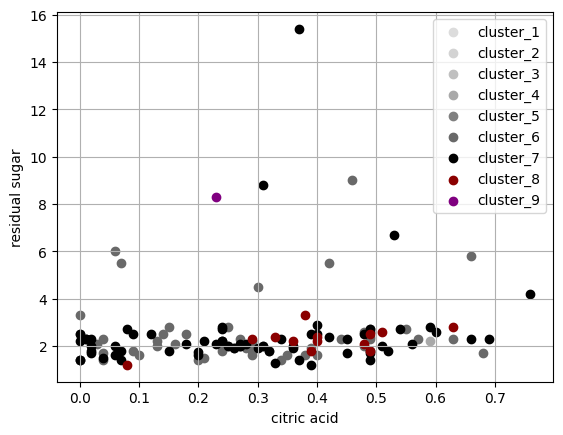

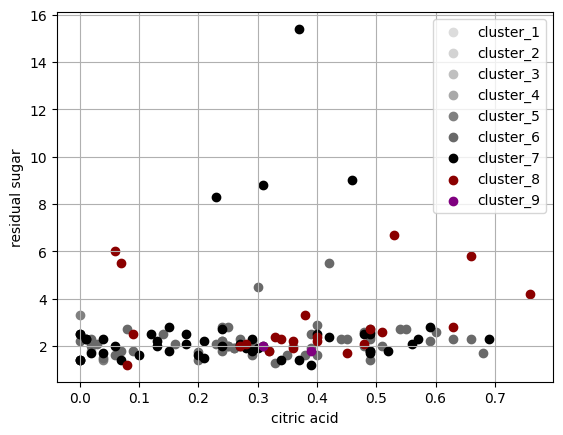

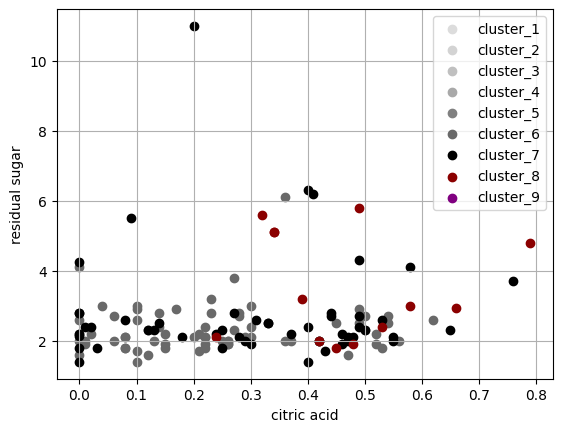

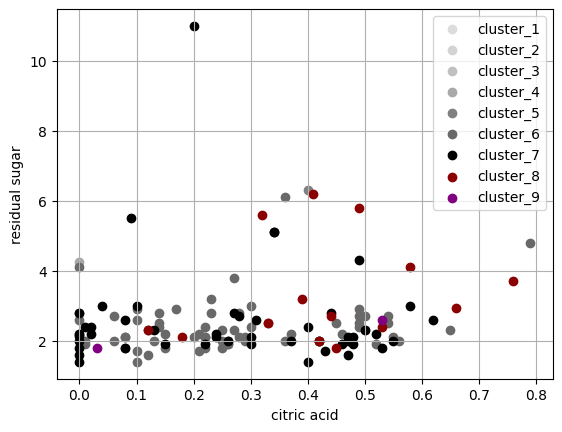

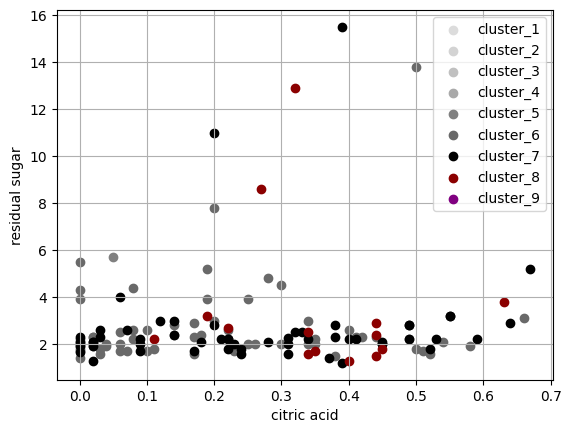

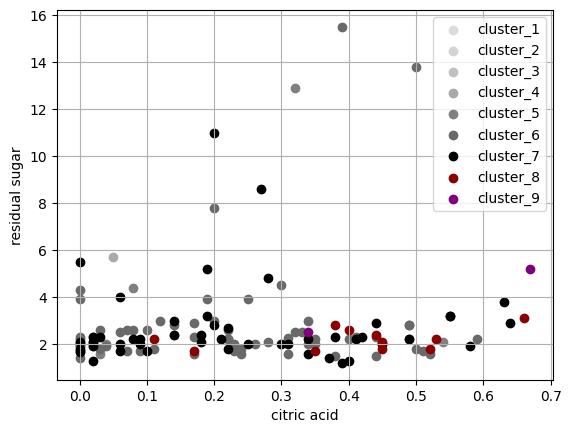

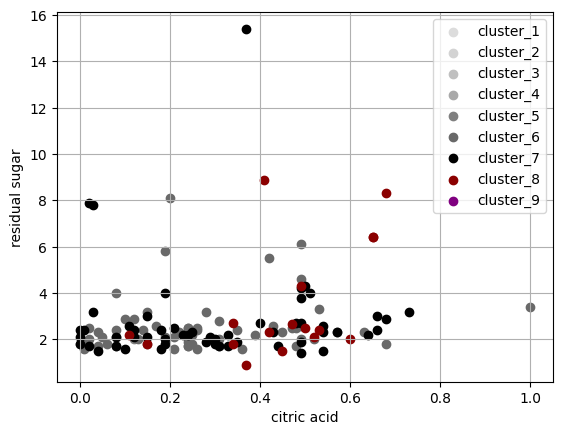

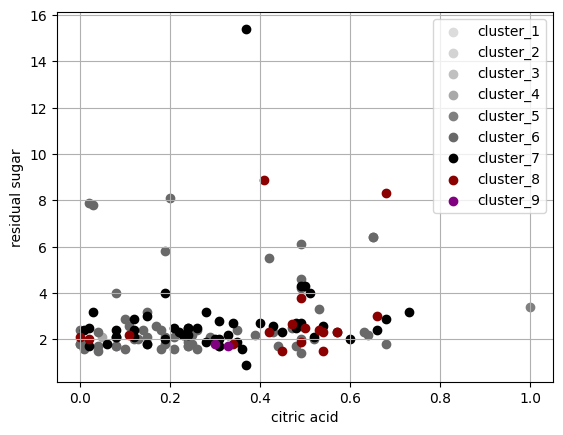

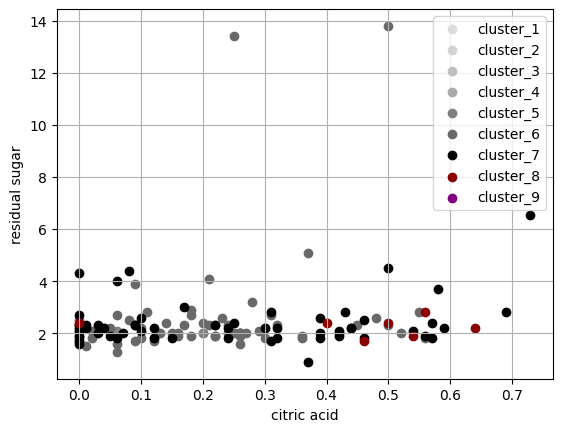

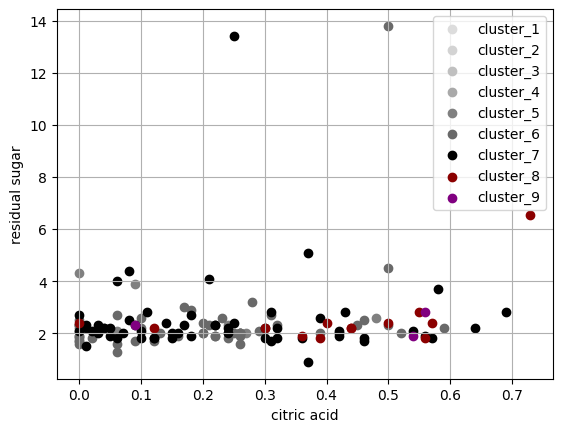

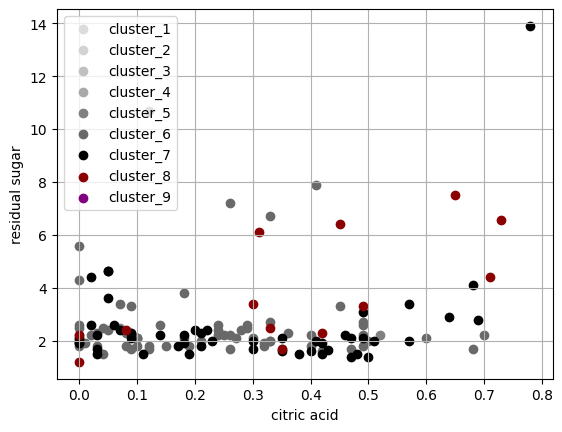

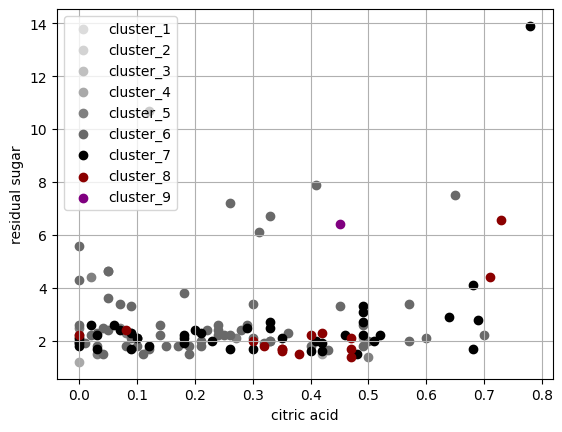

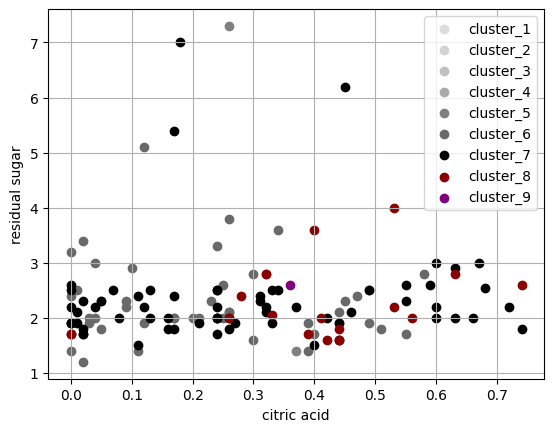

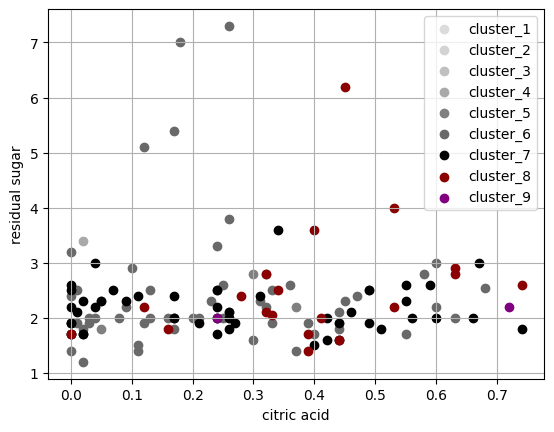

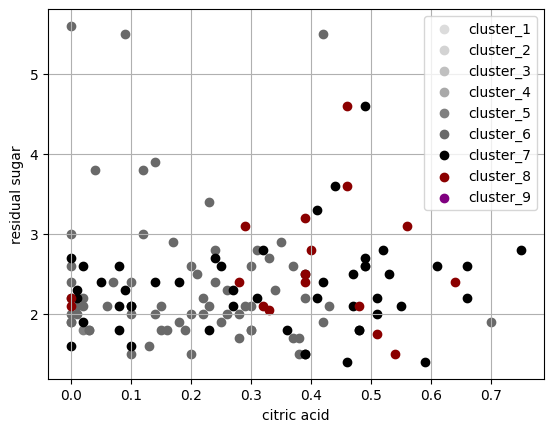

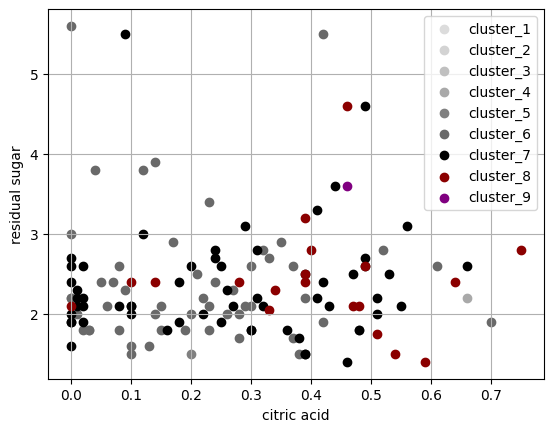

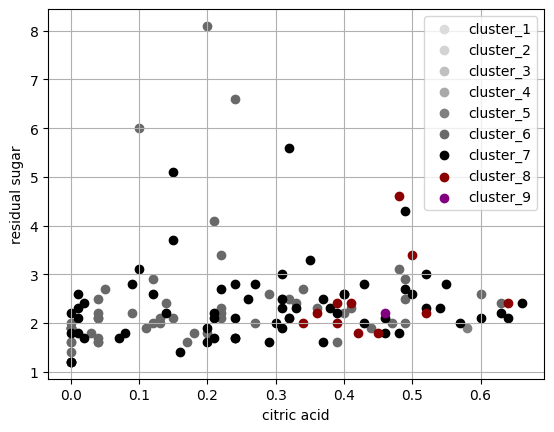

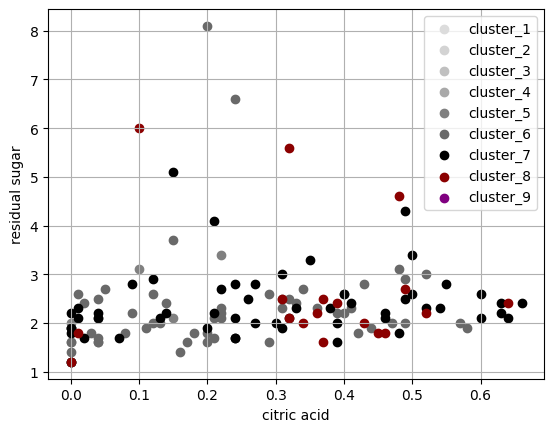

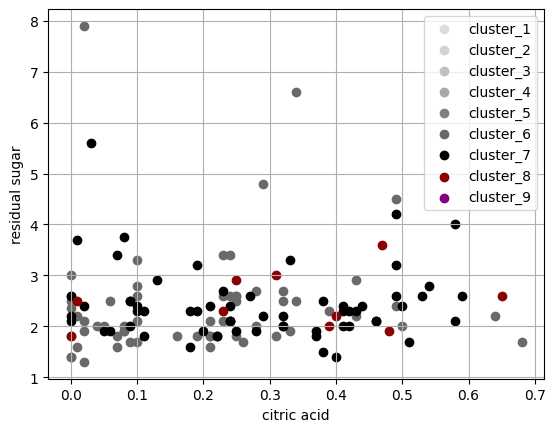

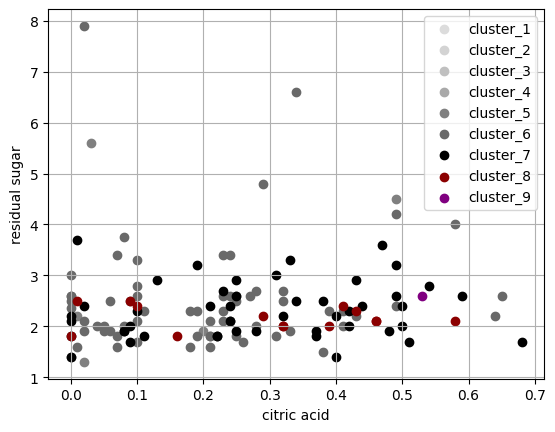

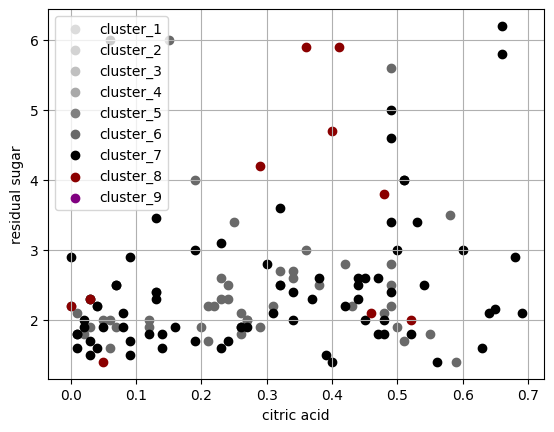

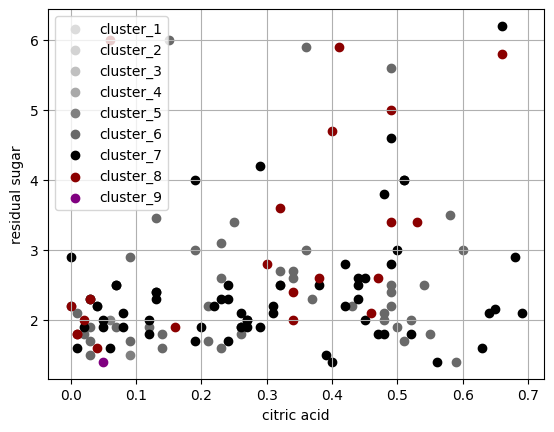

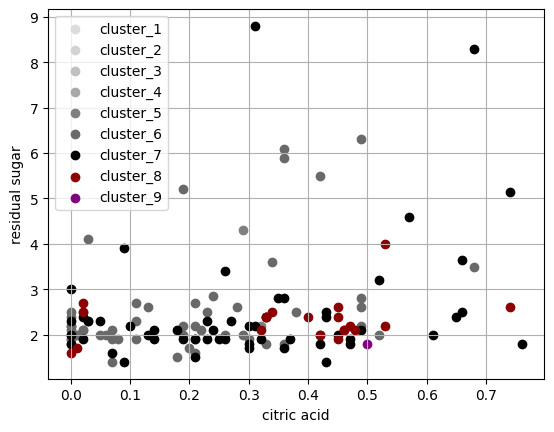

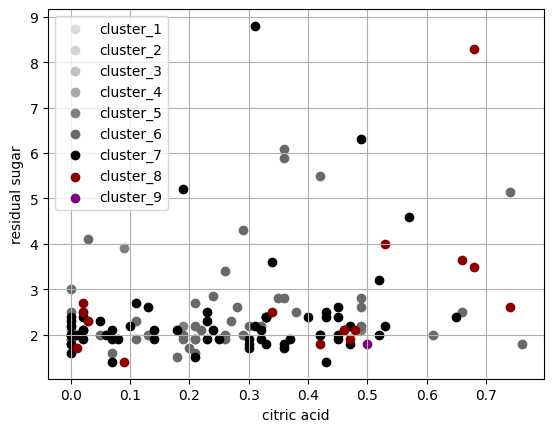

In [22]:
folds = cross_validation_split(dataset, 12)

for fold in folds:
	train_set = list(folds)
	train_set.remove(fold)
	train_set = sum(train_set, [])
	test_set = list()
	for row in fold:
		row_copy = list(row)
		test_set.append(row_copy)
		row_copy[-1] = None
	predicted = decision_tree(train_set, test_set, 8, 30)
	actual = [row[-1] for row in fold]
	clusterization_draw(test_set,predicted,2,3)
	clusterization_draw(test_set,actual,2,3)